In [1]:
import pandas as pd
import numpy as np
import shap

baseline_shap = pd.read_csv(
    "./results/lr_shap_baseline_feature_importance.csv"
)

baseline_shap


/Users/anurag/miniconda3/envs/shap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,feature,mean_abs_shap
0,ca,0.163336
1,thal,0.089152
2,sex,0.074624
3,cp,0.054535
4,exang,0.046874
5,slope,0.041988
6,thalach,0.036543
7,trestbps,0.023991
8,restecg,0.022758
9,chol,0.014659


In [2]:
df = pd.read_csv("./heart_clean.csv")

x = df.drop("target", axis=1)
y = df["target"]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

x_test_np = x_test.to_numpy()


In [3]:
def compute_shap_importance(model, scaler, X_train_np, X_test_np, feature_names):
    
    X_train_scaled = scaler.transform(X_train_np)
    X_test_scaled = scaler.transform(X_test_np)
    
    def predict_fn(X):
        return model.predict_proba(X)[:, 1]
    
    background = shap.sample(X_train_scaled, 50, random_state=42)
    
    explainer = shap.KernelExplainer(predict_fn, background)
    
    shap_values = explainer.shap_values(X_test_scaled)
    
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    
    return pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    }).sort_values(by="mean_abs_shap", ascending=False)


In [5]:
def inject_gaussian_noise(X, noise_level, random_state=42):
    rng = np.random.RandomState(random_state)
    noise = rng.normal(
        loc=0.0,
        scale=noise_level,
        size=X.shape
    )
    return X + noise


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Convert once
X_train_np = x_train.to_numpy()
X_test_np = x_test.to_numpy()
y_train_np = y_train.to_numpy()

noise_levels = [0.05, 0.10, 0.20]

results = []

for noise in noise_levels:
    
    # Inject noise
    X_train_noisy = inject_gaussian_noise(
        X_train_np,
        noise_level=noise,
        random_state=42
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_noisy)
    X_test_scaled = scaler.transform(X_test_np)
    
    # Train model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train_np)
    
    results.append({
        "noise_level": noise,
        "model": model,
        "scaler": scaler
    })


In [9]:
shap_results = {}

for r in results:
    noise = r["noise_level"]
    model = r["model"]
    scaler = r["scaler"]
    
    shap_df = compute_shap_importance(
        model,
        scaler,
        X_train_np,
        X_test_np,
        x.columns
    )
    
    shap_results[noise] = shap_df

    shap_df.to_csv(
        f"./results/lr_shap_noise_{noise}.csv",
        index=False
    )


100%|██████████| 61/61 [00:04<00:00, 12.34it/s]


In [10]:
#QUANTIFY INTERPRETABILITY STABILITY

import pandas as pd
from scipy.stats import spearmanr

baseline_shap = pd.read_csv(
    "./results/lr_shap_baseline_feature_importance.csv"
)

baseline_shap


,feature,mean_abs_shap
0,ca,0.163336
1,thal,0.089152
2,sex,0.074624
3,cp,0.054535
4,exang,0.046874
5,slope,0.041988
6,thalach,0.036543
7,trestbps,0.023991
8,restecg,0.022758
9,chol,0.014659


In [11]:
stability_results = []

for noise, shap_df in shap_results.items():
    
    merged = baseline_shap.merge(
        shap_df,
        on="feature",
        suffixes=("_baseline", "_noise")
    )
    
    rho, _ = spearmanr(
        merged["mean_abs_shap_baseline"],
        merged["mean_abs_shap_noise"]
    )
    
    stability_results.append({
        "noise_level": noise,
        "spearman_rank_correlation": rho
    })

stability_df = pd.DataFrame(stability_results)
stability_df


,noise_level,spearman_rank_correlation
0,0.05,0.978022
1,0.10,0.978022
2,0.20,0.857143


In [12]:
stability_df.to_csv(
    "./results/lr_interpretability_stability.csv",
    index=False
)


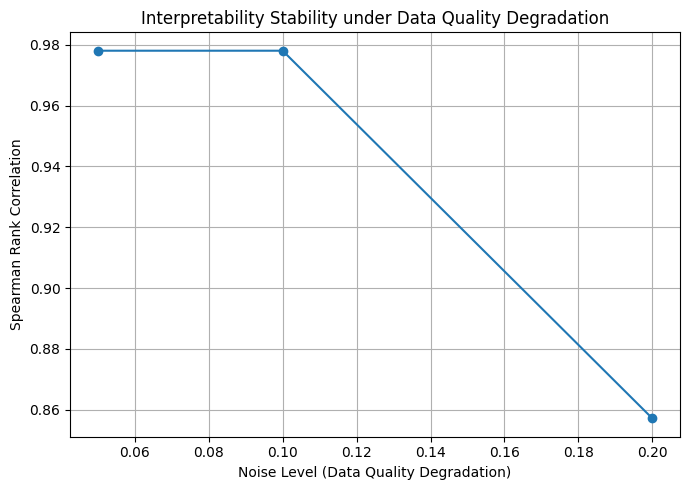

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(
    stability_df["noise_level"],
    stability_df["spearman_rank_correlation"],
    marker="o"
)

plt.xlabel("Noise Level (Data Quality Degradation)")
plt.ylabel("Spearman Rank Correlation")
plt.title("Interpretability Stability under Data Quality Degradation")
plt.grid(True)

plt.tight_layout()
plt.show()
